<img src="data.JPG">

In [126]:
#Load all required libraries
library(dplyr)
library(glmnet)
library(tidyr)
library(ggplot2)
library(reshape2)
library("ggpubr")
library(caret)
library(doParallel)
library(doMC)
registerDoMC(cores = 50)
library(pROC)
library(data.table)
library(tibble)

In [195]:
data_normalized=read.csv(file="20180206_ERPosNeg_Nanostring_normalized.csv",check.names=F,row.names=1)
head(data_normalized)
table(data_normalized$Group)
table(data_normalized$case)
dim(data_normalized)

,A2ML1,ABAT,ABCA13,ABCB4,ABHD2,ACTA2-AS1,ACTBP11,ACTBP2,ACTBP9,ACTC1,⋯,ZNF540,ZNF706,ZNF729,ZNF831,age,yearbbd,follow_years,impress,Group,case
50154,0.000000,0,0.000000,0,4.523562,0.000000,5.727920,8.317413,9.539159,0,⋯,0.000000,6.584963,6.000000,0.000000,50,1975,11.68,NP,ER+,Case
50170,0.000000,0,0.000000,0,4.954196,0.000000,6.169925,8.405141,9.623881,0,⋯,3.584963,5.954196,5.087463,1.000000,63,1970,12.31,PDWA,ER-,Case
50344,0.000000,0,0.000000,0,0.000000,0.000000,3.807355,10.818582,12.574830,0,⋯,0.000000,0.000000,0.000000,0.000000,49,1983,25.39,NP,cont,Case
50485,3.807355,0,4.169925,1,4.700440,6.066089,7.000000,9.428360,9.447083,0,⋯,4.906891,7.189825,8.348728,5.754888,50,1969,18.24,NP,cont,Case
50563,0.000000,0,5.459432,0,0.000000,0.000000,8.066089,10.423116,11.224605,0,⋯,3.169925,8.312883,8.614710,0.000000,65,1968,12.69,NP,ER-,Case
50590,0.000000,0,0.000000,0,5.807355,0.000000,6.392317,8.988685,10.121534,0,⋯,0.000000,6.629357,7.000000,0.000000,60,1974,18.57,PDWA,cont,Case



cont  ER-  ER+ 
  64   62   59 


   Case Control 
    126      59 

[1] 185 504

In [3]:
# data_normalized=(data_normalized[which(data_normalized$Group=='cont' & (data_normalized$case=='Case' | (data_normalized$case=='Control'))  ),])
# dim(data_normalized)
# head(data_normalized)
# table(data_normalized$case)

In [196]:
#reomve genes which are zeros along all subjects (504-488=16 genes)
data_normalized=data_normalized[, colSums(data_normalized != 0) > 0]
dim(data_normalized)

[1] 185 488

In [197]:
#remove age, yearbbd, follow_years, impress, group
data=data_normalized %>%select(-c(age,yearbbd,follow_years,impress,case))
head(data)
dim(data)
table(data$Group)

,A2ML1,ABAT,ABCA13,ABCB4,ABHD2,ACTA2-AS1,ACTBP11,ACTBP2,ACTBP9,ACTG1P1,⋯,WNT4,YTHDF3,ZCCHC18,ZFAND3,ZNF322,ZNF540,ZNF706,ZNF729,ZNF831,Group
50154,0.000000,0,0.000000,0,4.523562,0.000000,5.727920,8.317413,9.539159,6.022368,⋯,0.000000,7.971544,0.000000,6.741467,5.169925,0.000000,6.584963,6.000000,0.000000,ER+
50170,0.000000,0,0.000000,0,4.954196,0.000000,6.169925,8.405141,9.623881,6.339850,⋯,0.000000,7.965784,0.000000,5.977280,4.906891,3.584963,5.954196,5.087463,1.000000,ER-
50344,0.000000,0,0.000000,0,0.000000,0.000000,3.807355,10.818582,12.574830,5.954196,⋯,0.000000,10.007027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,cont
50485,3.807355,0,4.169925,1,4.700440,6.066089,7.000000,9.428360,9.447083,6.857981,⋯,3.807355,8.596190,4.523562,6.643856,7.199672,4.906891,7.189825,8.348728,5.754888,cont
50563,0.000000,0,5.459432,0,0.000000,0.000000,8.066089,10.423116,11.224605,7.734710,⋯,0.000000,9.861087,0.000000,8.169925,8.400879,3.169925,8.312883,8.614710,0.000000,ER-
50590,0.000000,0,0.000000,0,5.807355,0.000000,6.392317,8.988685,10.121534,6.977280,⋯,0.000000,8.550747,0.000000,7.179909,5.807355,0.000000,6.629357,7.000000,0.000000,cont


[1] 185 483


cont  ER-  ER+ 
  64   62   59 

In [222]:
levels(data$Group)

[1] "cont" "ER-"  "ER+"

In [223]:
levels(data$Group)=c('cont','ERn','ERp')
levels(data$Group)

[1] "cont" "ERn"  "ERp"

In [11]:
# # ER+ and ER- as case 
# levels(data$Group)=c('Control','Case','Case')
# table(data$Group)

In [ ]:
glmnet_selected_features=find_selected_features_glmnet(data)
glmnet_selected_features

`geom_smooth()` using method = 'loess'


In [335]:
#' A find_selected_features_glmnet
#'
#' This function find the best lamda based on the best alpha and return the non zero features selected by glmnet
#'https://stats.stackexchange.com/questions/97777/variablity-in-cv-glmnet-results
#' @param data The matrix you want to find the best selected features using glmnet
#' @keywords glmnet
#' @export
#' @examples glmnet_selected_features=find_selected_features_glmnet(data)
#' find_selected_features_glmnet()
#'
#'


find_selected_features_glmnet  <- function(data) {

bestalpha=findalphaMulticlass(data)
result=findlamdaMulticlass(data,bestalpha)
selected_features=result$consensus_genes  
return(selected_features)
    
    }

#  features selection using glmnet 

`geom_smooth()` using method = 'loess'


[1] 0.4444444

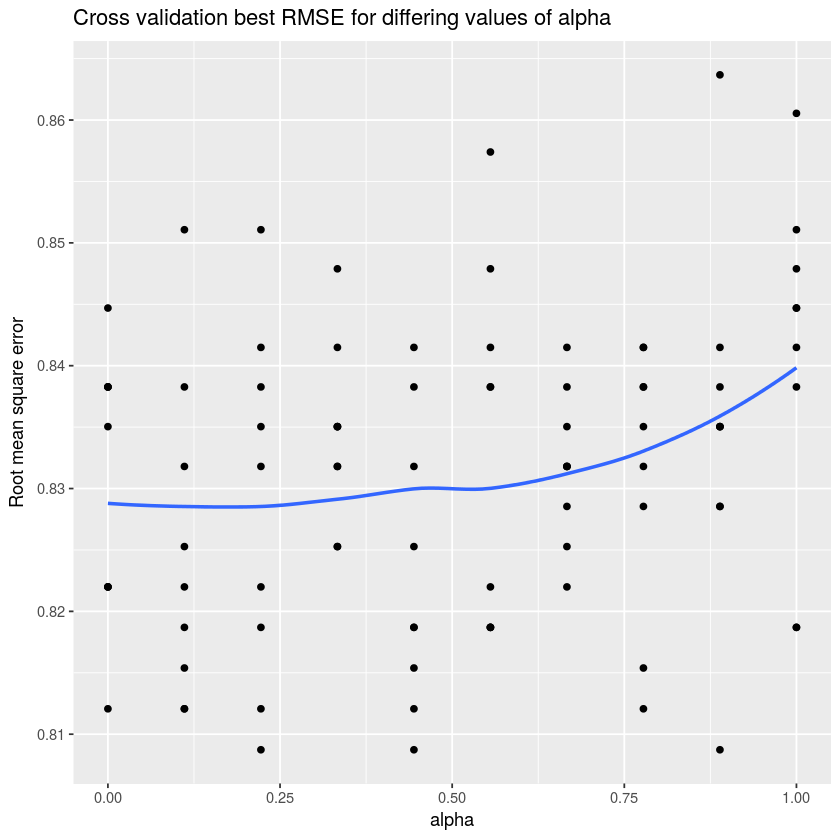

In [16]:
# selected genes with glmnet R packages 
#Find the best alpha
bestalpha=findalphaMulticlass(data)
bestalpha

In [311]:
#' A Find the best alpha Function
#'
#' This function find the best alpha which give the least square root error
#'http://ellisp.github.io/blog/2016/08/13/fitbit-lasso
#' @param data The matrix you want to find the alpha
#' @keywords alpha
#' @export
#' @examples bestalpha=findalphaMulticlassdata)
#' findalphaMulticlass()
#'
#'

findalphaMulticlass  <- function(data)  {
set.seed(123)
alphas <- seq(from = 0, to  = 1, length.out = 10)
numberOFrepeats=10
res <- matrix(0, nrow = length(alphas), ncol = numberOFrepeats) # five columns for results - five repeats of each CV run

x=data.matrix(data[,1:(ncol(data)-1)])
y=as.factor(data[,ncol(data)])
    
for(i in 1:length(alphas)){
   for(j in 2:numberOFrepeats){
      cvmod <- cv.glmnet(x, y , alpha = alphas[i],family='multinomial',nfolds=10, 
                   standardize=TRUE, type.measure='class')
      res[i, c(1, j)] <- c(alphas[i], sqrt(min(cvmod$cvm)))
   }
}
res <- data.frame(res)
res$average_rmse <- apply(res[ , 2:numberOFrepeats], 1, mean)
res <- res[order(res$average_rmse), ]
names(res)[1] <- "alpha"

res1 <- res %>%
   select(-average_rmse) %>%
   gather(trial, rmse, -alpha)
    
  p= res1 %>% ggplot(aes(x = alpha, y = rmse)) +
   geom_point() +
   geom_smooth(se = FALSE) +
   labs(y = "Root mean square error") +
   ggtitle("Cross validation best RMSE for differing values of alpha")

   print(plot(p))
# best alpha varies according to the random seed set earlier but with seed 123 it is 0.22
  bestalpha <- res[1, 1]
    return(bestalpha)

}

In [147]:
#Find the best lampda
result=findlamdaMulticlass(data,bestalpha)
selected_features=result$consensus_genes
selected_features

[[1]]
[1] "CHUK"   "MT2A"   "PARP3"  "PELI2"  "SNCA"   "TUBA4A"

[[2]]
[1] "CHUK"   "MT2A"   "PARP3"  "PELI2"  "SNCA"   "TUBA4A"

[[3]]
[1] "CHUK"   "MT2A"   "PARP3"  "PELI2"  "SNCA"   "TUBA4A"

[[4]]
[1] "CHUK"   "MT2A"   "PARP3"  "PELI2"  "SNCA"   "TUBA4A"

[[5]]
[1] "(Intercept)" "CHUK"        "MT2A"        "PARP3"       "PELI2"      
[6] "SNCA"        "TUBA4A"     

[[6]]
[1] "CHUK"   "MT2A"   "PARP3"  "PELI2"  "SNCA"   "TUBA4A"

[[7]]
  [1] "ABAT"        "ACTG2"       "ADK"         "AK5"         "APOC1"      
  [6] "APOC4-APOC2" "ARCN1"       "ARIH1"       "ATG3"        "ATP11C"     
 [11] "ATP12A"      "ATP5G3"      "ATP6V0B"     "AURKA"       "BHMT2"      
 [16] "BLK"         "BTBD11"      "C14orf1"     "C6orf62"     "CAMK2B"     
 [21] "CCL4"        "CD109"       "CDC42"       "CDH2"        "CDK2"       
 [26] "CDK8"        "CDKN1C"      "CHI3L1"      "CHST11"      "CHUK"       
 [31] "CLDN19"      "COPS6"       "COX7B"       "CPS1"        "CPVL"       
 [36] "CR2"         "CSNK2A1"     "CTSL"        "CXCR4"       "CYP2D8P"    
 [41] "CYP4Z1"      "DCT"         "DCUN1D5"     "DCXR"        "DERA"       
 [46] "DHCR7"       "DLK2"        "DNAJA1"      "DPP4"        "DSG1"       
 [51] "DUOX2"       "DYNLL2"      "EGR2"        "ENY2"        "ETF1"       
 [56] "FAM196B"     "FCN2"        "FGFR4"       "FLG"         "FN1"        
 [61] "FNDC1"       "GCNT2"       "GEMIN2"      "GK"          "GLDC"       
 [66] "GLUD2"       "GPNMB"       "GPR137B"     "GPT"         "GRIA4"      
 [71] "GSPT1"       "GSTM5"       "GSTP1"       "H2AFJ"       "H2AFX"      
 [76] "HGD"         "HILPDA"      "HIST1H2AH"   "HIST1H4I"    "HIST3H2A"   
 [81] "HLA-DQB1"    "HLA-L"       "HMCN2"       "HMGA1"       "HMGCS2"     
 [86] "HNRNPUP1"    "HPD"         "HPX"         "HSD17B7P2"   "HSP90B2P"   
 [91] "HSPA2"       "HSPA5"       "ID2"         "IGFN1"       "IGHG3"      
 [96] "IGKV1-6"     "ITGA3"       "ITPRIPL1"    "KPNA2"       "L1CAM"      
[101] "LDHAP4"      "LDHAP7"      "LMO7"        "LRPAP1"      "LRRC4B"     
[106] "LST1"        "LYZ"         "MAPRE3"      "MET"         "MMP9"       
[111] "MRTO4"       "MT2A"        "MTRNR2L10"   "MTSS1"       "MYH6"       
[116] "MYOM3"       "NKD2"        "NPL"         "NR4A2"       "OSTC"       
[121] "PABPC1P4"    "PAH"         "PANK1"       "PAQR6"       "PARP3"      
[126] "PAX5"        "PELI2"       "PI16"        "PIN4"        "PITX1"      
[131] "PLXNB3"      "PLXNC1"      "POLR2J2"     "POLR2K"      "POU5F1"     
[136] "PPP1R3C"     "PROCR"       "PRODH"       "PROX1"       "PRSS3P1"    
[141] "PRSS3P2"     "PSAP"        "PSMB1"       "PSMC1"       "PSMD11"     
[146] "RAB6A"       "RAPGEF4"     "RGN"         "RGS1"        "RGS13"      
[151] "RNF103"      "RNF128"      "RRP15"       "SARDH"       "SCN2B"      
[156] "SERP1"       "SLC14A1"     "SLC16A4"     "SLC20A1"     "SLC29A2"    
[161] "SLC37A2"     "SLC39A14"    "SLC5A6"      "SLC7A5"      "SNCA"       
[166] "SOAT1"       "SPP1"        "SRPX"        "STARD10"     "STX2"       
[171] "SZRD1"       "TBC1D3C"     "TF"          "TLK2"        "TM7SF2"     
[176] "TMEM107"     "TMEM14A"     "TMEM183A"    "TNK1"        "TPCN2"      
[181] "TTC36"       "TTC39C"      "TTYH2"       "TUBA4A"      "TUBB3"      
[186] "UBBP1"       "UBE2D2"      "UBE2G1"      "UBE2L3"      "UBE2N"      
[191] "UCHL1"       "UIMC1"       "UPB1"        "USB1"        "WBP1L"      
[196] "WDR91"       "WNT4"        "ZNF540"      "ZNF729"     

[[8]]
[1] "CHUK"   "PARP3"  "PELI2"  "SNCA"   "TUBA4A"

[[9]]
[1] "CHUK"   "MT2A"   "PARP3"  "PELI2"  "SNCA"   "TUBA4A"

[[10]]
[1] "CHUK"   "PARP3"  "PELI2"  "SNCA"   "TUBA4A"

[1] "CHUK"   "PARP3"  "PELI2"  "SNCA"   "TUBA4A"

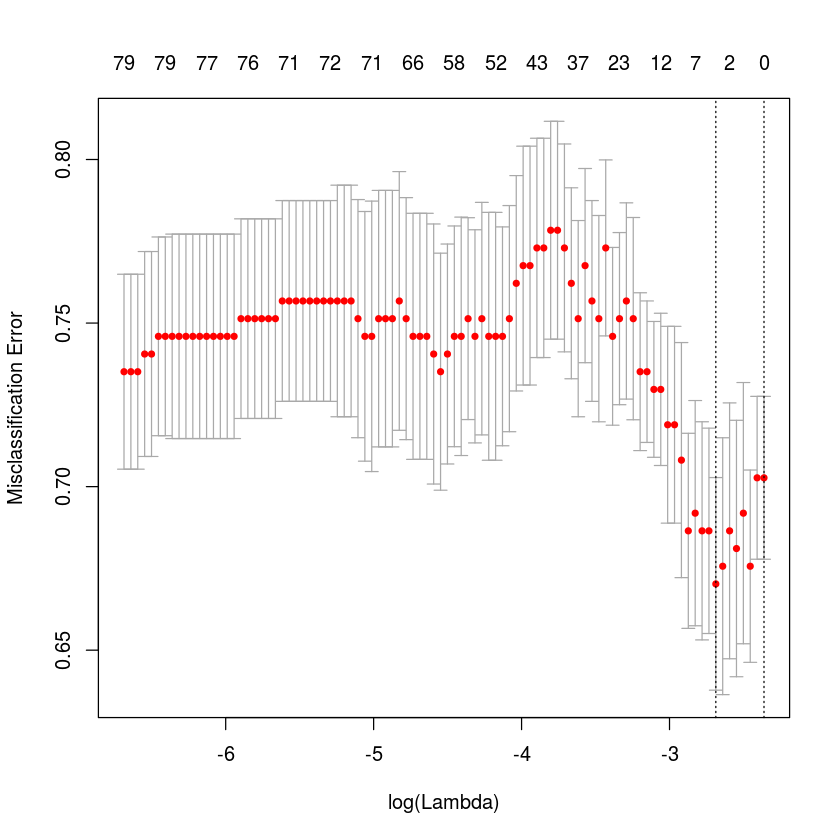

In [150]:
plot(result$model)

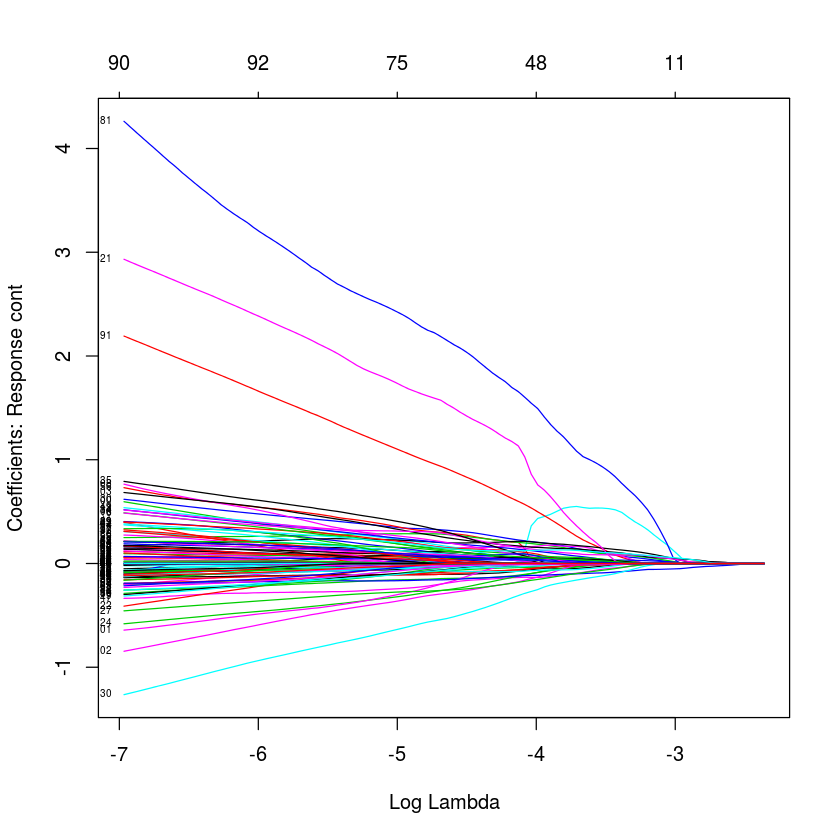

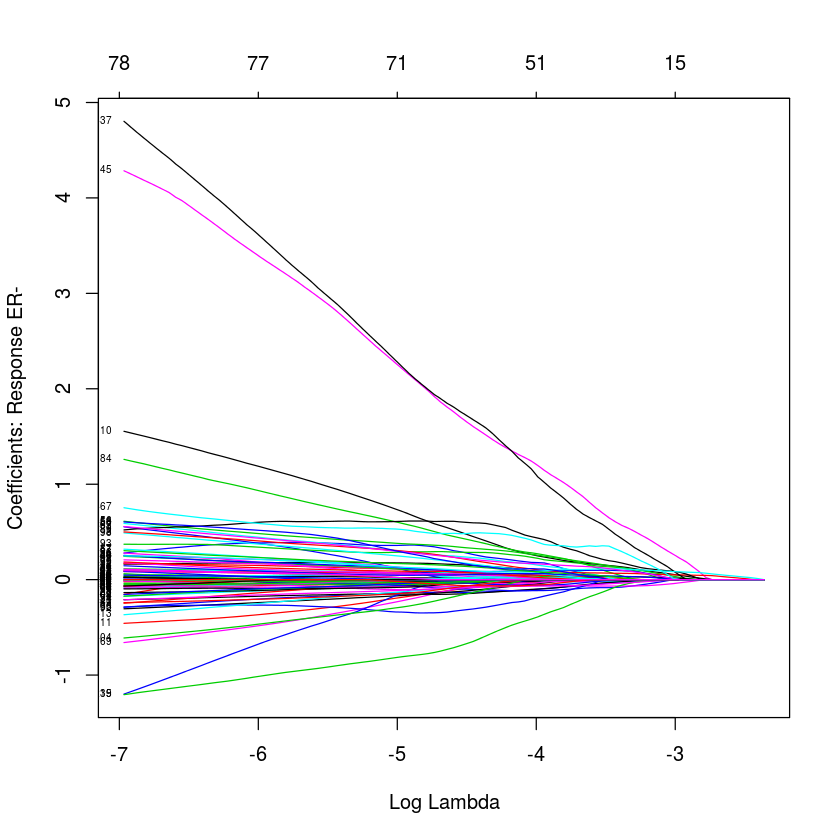

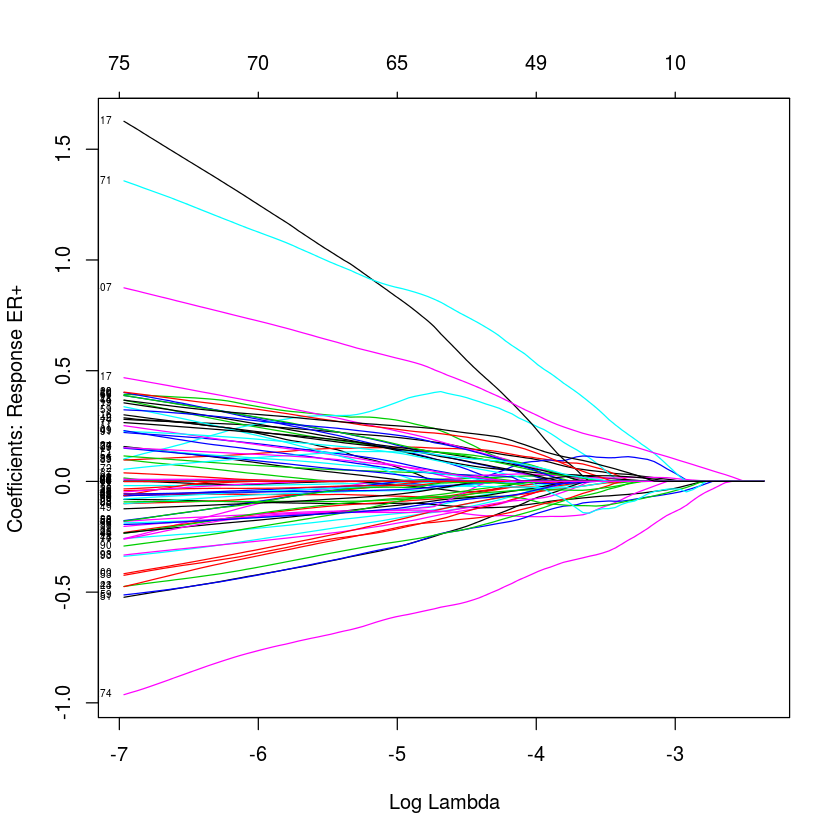

In [151]:
#https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html
plot(result$model$glmnet.fit, xvar="lambda", label=TRUE)

In [346]:
#' A Find the best lamda Function
#'
#' This function find the best lamda based on the best alpha and return the non zero features selected by glmnet
#'https://stats.stackexchange.com/questions/97777/variablity-in-cv-glmnet-results
#' @param data The matrix you want to find the best lampda and alpha you find from findalpha function
#' @param bestalpha the parameter alpha 
#' @keywords lamda
#' @export
#' @examples bestlamda=findalphaMulticlass(data,bestalpha)
#' findlamdaMulticlass()
#'
#'

findlamdaMulticlass  <- function(data,bestalpha)  {
    
res = list()
    
lambdas = NULL
genes_list=list()
    

x=data.matrix(data[,1:(ncol(data)-1)])
y=as.factor(data[,ncol(data)])   
    
for (j in 1:10)
{
for (i in 1:100)
{
  #fit <- cv.glmnet(x, y, family='binomial',nfolds=10, 
       #            standardize=TRUE, type.measure='class')
    
    #cv.glmnet does NOT search for values for alpha. A specific value should be supplied, else alpha=1 is assumed by default.
    
    fit <- cv.glmnet(x, y, family='multinomial',nfolds=10, 
                   standardize=TRUE, type.measure='class',alpha=1)
    
  errors = data.frame(fit$lambda,fit$cvm)
  lambdas <- rbind(lambdas,errors)
}
# take mean cvm for each lambda
lambdas <- aggregate(lambdas[, 2], list(lambdas$fit.lambda), mean)

# select the best one
bestindex = which(lambdas[2]==min(lambdas[2]))
bestlambda = lambdas[bestindex,1]
    
res$bestlambda=bestlambda
res$model=fit    
lambdas = NULL
cv.lasso<- glmnet(x, y,lambda=bestlambda,family='multinomial',standardize=TRUE)

a=0
for (i in 1:length(coef(cv.lasso, s=bestlambda))){
     a=a+as.matrix(coef(cv.lasso, s=bestlambda)[[i]])
}
genes_list[[j]] <- a %>% data.frame() %>% rownames_to_column() %>% filter(X1 != 0 ) %>%
          column_to_rownames('rowname') %>% rownames
    
}
    
print(plot(fit$model))
print(plot(fit$model$glmnet.fit, xvar="lambda", label=TRUE))
    

    
genes_list_consensus=Reduce(intersect,genes_list) 
genes_list_consensus=make.names(genes_list_consensus, unique=TRUE)
    
res$consensus_genes=genes_list_consensus
res$genes_list=genes_list   
    
return(res)
    
    }

In [152]:
lasso_data=data %>% select(result$consensus_genes,ncol(data))
head(lasso_data)
dim(lasso_data)

,CHUK,PARP3,PELI2,SNCA,TUBA4A,Group
50154,6.357552,3.700440,0.000000,2.321928,1.584963,ER+
50170,5.832890,4.584963,2.807355,2.000000,4.700440,ER-
50344,7.599913,0.000000,0.000000,0.000000,0.000000,cont
50485,6.714246,6.768184,0.000000,0.000000,0.000000,cont
50563,8.543032,5.087463,0.000000,0.000000,0.000000,ER-
50590,6.714246,4.584963,0.000000,0.000000,1.584963,cont


[1] 185   6

In [153]:
levels(lasso_data$Group)

[1] "cont" "ER-"  "ER+"

In [155]:
levels(lasso_data$Group)=c('cont','ERn','ERp')

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

,Sensitivity,Specificity,Pos Pred Value,Neg Pred Value,Precision,Recall,F1,Prevalence,Detection Rate,Detection Prevalence,Balanced Accuracy
Class: cont,0.5166667,0.6282174,0.4489744,0.7018226,0.4489744,0.5166667,0.4711685,0.3460013,0.1783389,0.4221432,0.5724420
Class: ERn,0.3846154,0.7903333,0.5005051,0.7203948,0.5005051,0.3846154,0.4233607,0.3350403,0.1295243,0.2686818,0.5874744
Class: ERp,0.4303030,0.7456923,0.4239776,0.7450587,0.4239776,0.4303030,0.4139071,0.3189584,0.1358069,0.3091750,0.5879977


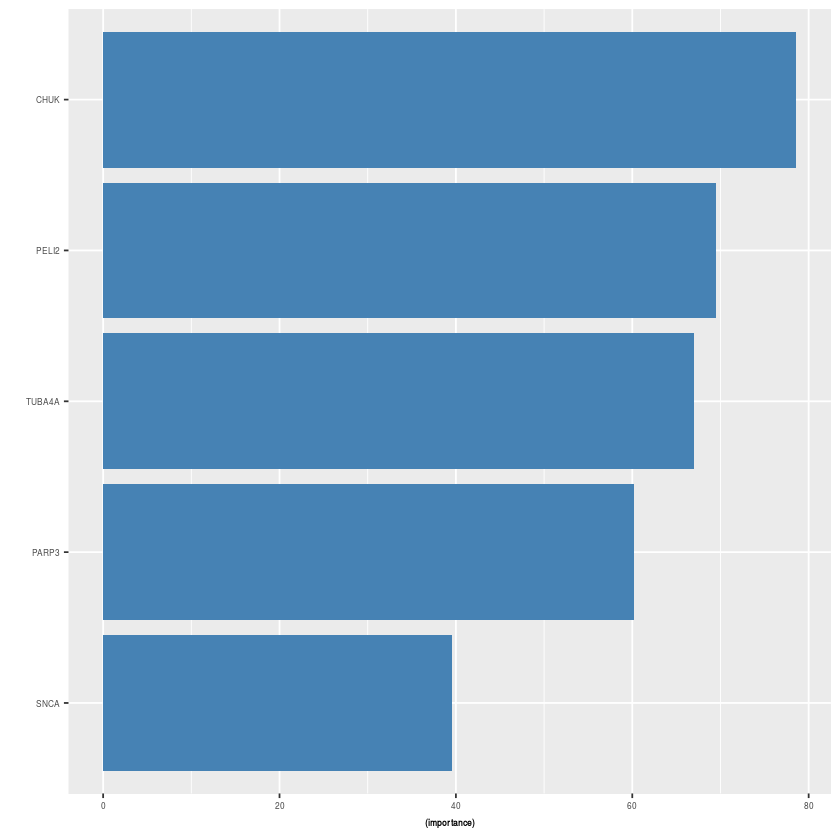

In [309]:
numberoffolds=5
confussionmatrix=PerformanceMulticlass(lasso_data,numberoffolds,"lasso genes")
confussionmatrix

Using Group as id variables


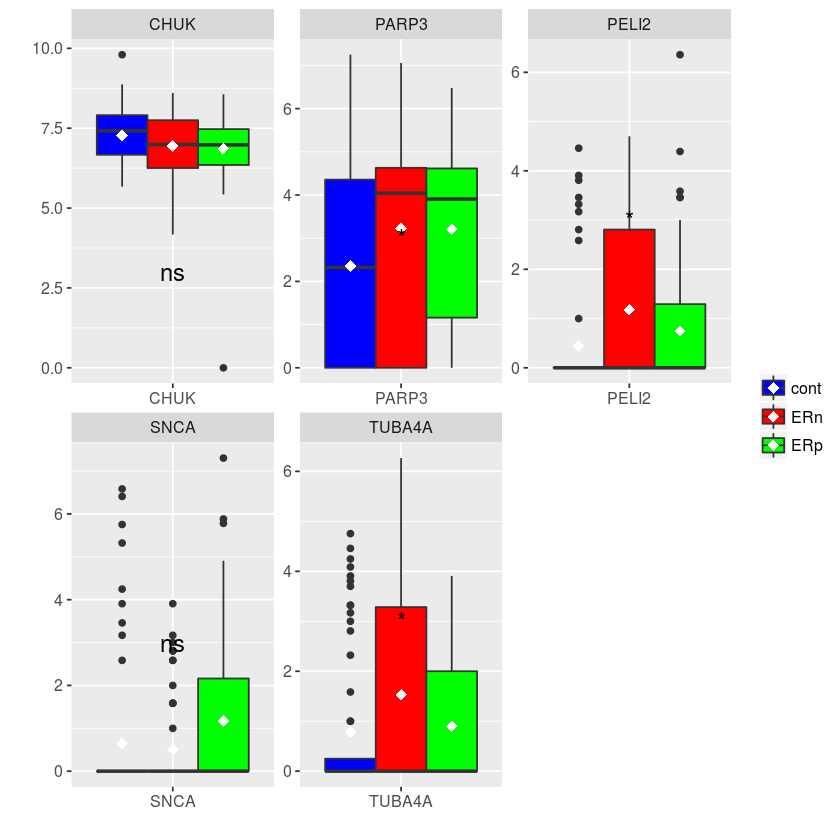

In [304]:
plotBoxMulticlass(lasso_data)

#  features selection using statistics test 

In [327]:
anova_selected_features=find_selected_features_anova(data)
anova_selected_features

[1] "MT2A"
[1] "PARP3"
[1] "PELI2"
[1] "TUBA4A"


[1] "MT2A"   "PARP3"  "PELI2"  "TUBA4A"

In [336]:
#' A find_selected_features_anova
#'
#' This function find the statistically differenatiated featuers using ANOVA test
#' @param data The matrix you want to find the best selected features using ANOVA
#' @keywords ANOVA
#' @export
#' @examples anova_selected_features=find_selected_features_anova(data)
#' find_selected_features_anova()
#'
#'


find_selected_features_anova <- function(data) {

# Just print the signficant metabolites <0.05 using ANOVA
signficant_metab1='NA'
for (i in 1:(ncol(data)-1)){
a=summary(aov(data[,i]~ data[,ncol(data)],data=data))  
if((a[[1]][1,5]) <=0.05 )
{print(colnames(data)[i])
signficant_metab1=append(signficant_metab1,colnames(data)[i])} 
}
signficant_metab1=signficant_metab1[-1]
return(signficant_metab1)
    
    }


In [272]:
significant_data=data.frame(data[,signficant_metab1],label=data[,ncol(data)])
head(significant_data)
dim(significant_data)

,MT2A,PARP3,PELI2,TUBA4A,label
50154,8.550747,3.700440,0.000000,1.584963,ERp
50170,8.055282,4.584963,2.807355,4.700440,ERn
50344,12.802516,0.000000,0.000000,0.000000,cont
50485,9.310613,6.768184,0.000000,0.000000,cont
50563,10.443980,5.087463,0.000000,0.000000,ERn
50590,10.087463,4.584963,0.000000,1.584963,cont


[1] 185   5

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

,Sensitivity,Specificity,Pos Pred Value,Neg Pred Value,Precision,Recall,F1,Prevalence,Detection Rate,Detection Prevalence,Balanced Accuracy
Class: cont,0.5615385,0.5784348,0.4200000,0.7106153,0.4200000,0.5615385,0.4790196,0.3460013,0.19442074,0.4703967,0.5699866
Class: ERn,0.3551282,0.7416667,0.4249534,0.6936923,0.4249534,0.3551282,0.3847966,0.3350403,0.11929034,0.2910384,0.5483974
Class: ERp,0.2939394,0.7853846,0.3543939,0.7072432,0.3543939,0.2939394,0.3148338,0.3189584,0.09253201,0.2385649,0.5396620


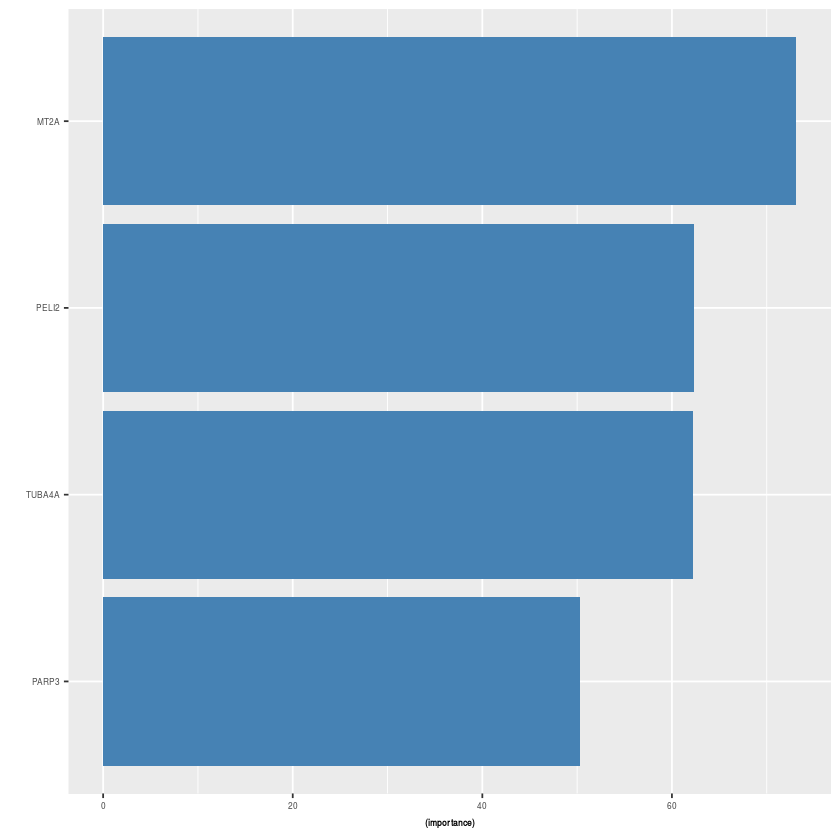

In [308]:
numberoffolds=5
confussionmatrix=PerformanceMulticlass(significant_data,numberoffolds,"Sta signficant genes")
confussionmatrix

Using label as id variables


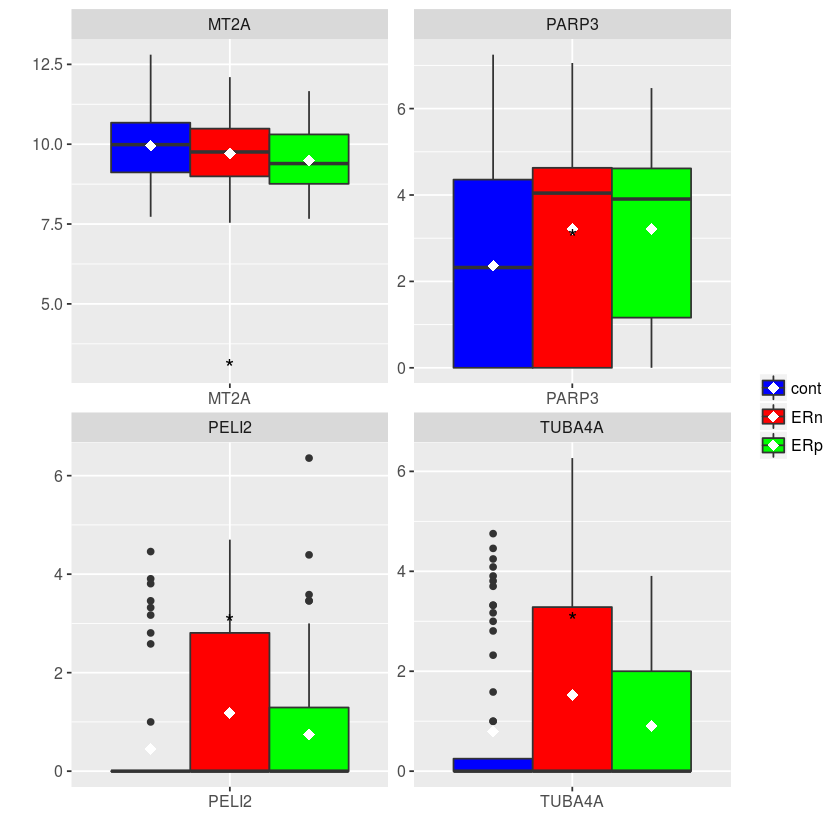

In [303]:
plotBoxMulticlass(significant_data)

#  features selection using CARET  recursive feature elimination

In [338]:
dim(data)

[1] 185 483

[1] "UBE2Q2"   "ALDOA"    "SNORA57"  "PELI2"    "SNORA74B" "ARIH1"   
 [7] "CUL3"     "CLCN7"    "BTBD11"   "PSAP"     "RRM2"     "SRPX"    
[13] "ACTG1P1"  "IFT20"    "NKD2"     "PIN4"     "FTH1P16"  "UCHL1"   
[19] "ITGA3"    "TRPM6"    "RAPGEF4"  "LMO7"     "RNF11"    "HSPA5"

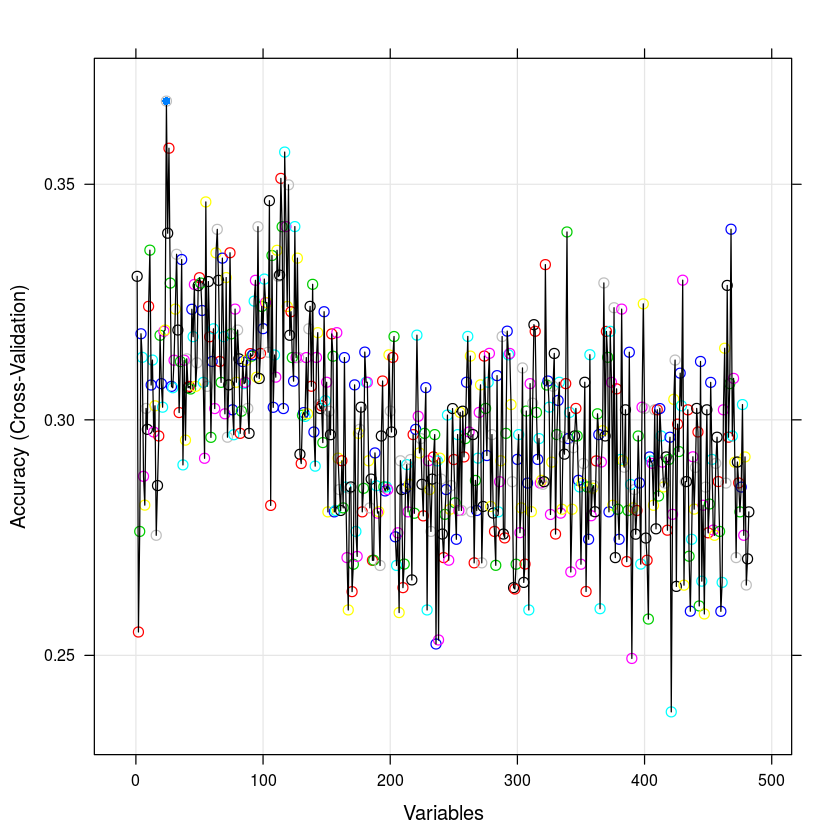

In [349]:
rfe_selected_features=find_selected_features_rfe(data)
rfe_selected_features

In [348]:
#' A find_selected_features_rfe
#'
#' This function find the features selected by the recursive feature elimination 
#' @param data The matrix you want to find the best selected features using ANOVA
#' @keywords ANOVA
#' @export
#' @examples rfe_selected_features=find_selected_features_rfe(data)
#' find_selected_features_rfe()
#'
#'

find_selected_features_rfe <- function(data) {
set.seed(123)
control <- rfeControl(functions=rfFuncs, method="cv", number=10)
rfe.train <- rfe(data[,1:(ncol(data)-1)], data[,ncol(data)]  , sizes=1:(ncol(data)-1), rfeControl=control)
print(plot(rfe.train, type=c("g", "o"), cex = 1.0, col = 1:(ncol(data)-2)))
return(rfe.train$optVariables)
#length(predictors(rfe.train))     
    
    }


In [347]:

length(predictors(rfe.train)) 

[1] 287

In [350]:
rfe_data=data.frame(data[,rfe_selected_features,drop=F],label=data[,ncol(data)])
head(rfe_data)
dim(rfe_data)

,UBE2Q2,ALDOA,SNORA57,PELI2,SNORA74B,ARIH1,CUL3,CLCN7,BTBD11,PSAP,⋯,PIN4,FTH1P16,UCHL1,ITGA3,TRPM6,RAPGEF4,LMO7,RNF11,HSPA5,label
50154,6.857981,10.10198,14.76415,0.000000,11.42836,6.475733,5.129283,4.584963,0,10.357552,⋯,0.000000,12.02479,3.321928,4.700440,0.00000,2.807355,2.584963,7.672425,3.459432,ERp
50170,6.392317,9.78627,14.72531,2.807355,11.81738,6.459432,5.459432,5.044394,0,9.567956,⋯,0.000000,11.16992,0.000000,4.584963,0.00000,2.584963,3.700440,7.238405,3.700440,ERn
50344,8.689998,12.80050,17.42884,0.000000,14.13258,0.000000,0.000000,0.000000,0,12.354800,⋯,0.000000,13.05002,0.000000,0.000000,0.00000,0.000000,0.000000,7.918863,0.000000,cont
50485,7.098032,10.37938,15.16887,0.000000,11.64250,4.169925,0.000000,4.000000,0,9.276124,⋯,5.392317,11.00703,0.000000,3.584963,6.33985,4.523562,7.044394,7.665336,5.727920,cont
50563,8.463524,11.63436,16.71138,0.000000,13.38775,5.882643,0.000000,5.882643,0,11.599913,⋯,0.000000,13.51027,0.000000,0.000000,6.70044,0.000000,5.087463,9.483816,4.857981,ERn
50590,7.539159,11.09276,15.54397,0.000000,12.13571,7.312883,5.169925,4.857981,0,10.279611,⋯,0.000000,11.80816,0.000000,6.459432,0.00000,4.169925,4.857981,8.632995,1.584963,cont


[1] 185  25

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

,Sensitivity,Specificity,Pos Pred Value,Neg Pred Value,Precision,Recall,F1,Prevalence,Detection Rate,Detection Prevalence,Balanced Accuracy
Class: cont,0.3743590,0.6173188,0.3477564,0.6483117,0.3477564,0.3743590,0.3574717,0.3460013,0.12936621,0.3793346,0.4958389
Class: ERn,0.3705128,0.6273333,0.3458120,0.6587090,0.3458120,0.3705128,0.3526085,0.3350403,0.12440335,0.3718824,0.4989231
Class: ERp,0.1893939,0.7226410,0.2255051,0.6563678,0.2255051,0.1893939,0.2030447,0.3189584,0.05978347,0.2487830,0.4560175


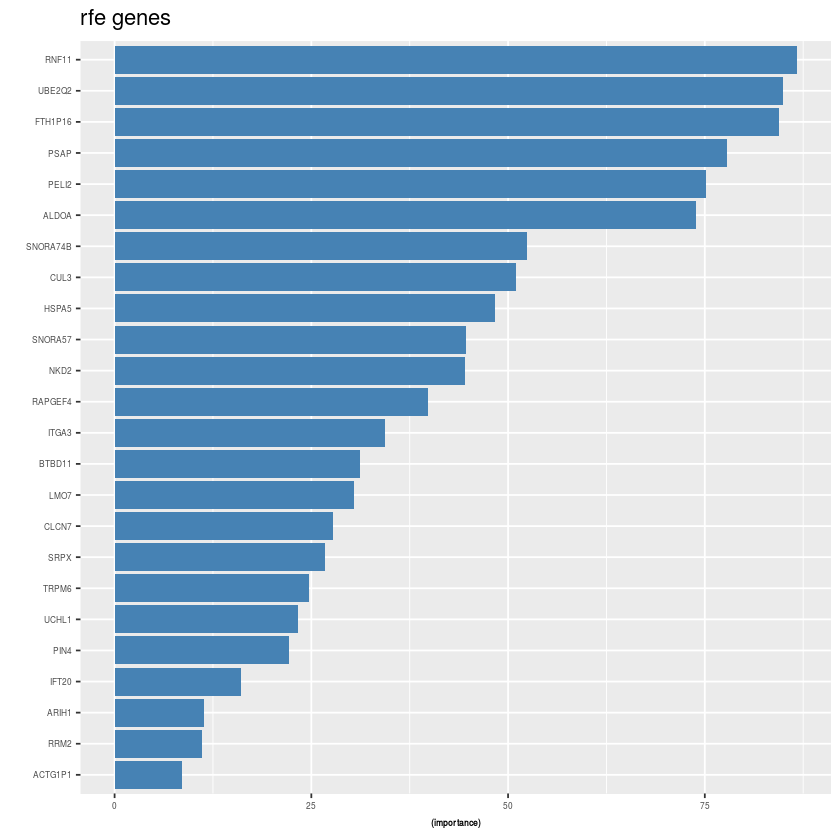

In [352]:
numberoffolds=5
confussionmatrix=PerformanceMulticlass(rfe_data,numberoffolds,"rfe genes")
confussionmatrix

Using label as id variables


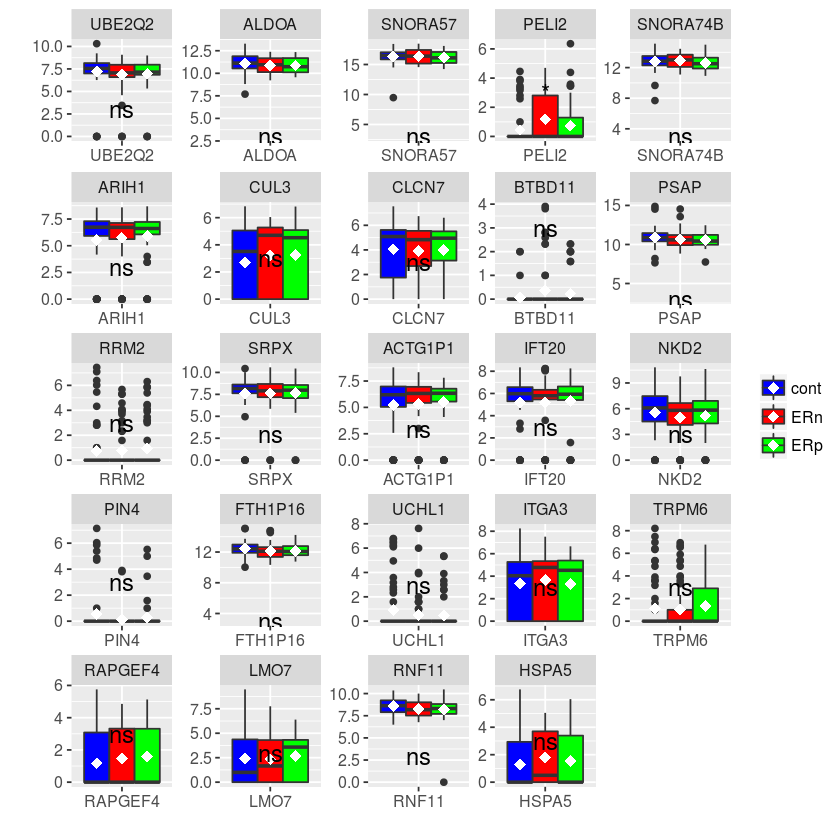

In [351]:
plotBoxMulticlass(rfe_data)

In [300]:
#' A plotBoxMulticlass Function
#'
#' This function plot the box plot of the data if it has group with more than two classes
#' @param data The data where the samples are in rows and columns are in cloumns with the data label in the last column 
#' @keywords ggplot
#' @export
#' @examples plotBoxMulticlass(data)
#' plotBoxMulticlass()
#'
#'

plotBoxMulticlass <- function(data) {
    require(ggplot2)
    require(ggpubr)
    melted_data<- melt(data)
p <- ggplot(data =melted_data, aes(x=variable, y=value,fill=melted_data[,1])) + 
  geom_boxplot()+scale_fill_manual(values=c("blue", "red","green"))+
         stat_summary(fun.y="mean", color="white", geom="point",shape=18, size=3,position=position_dodge(width=0.75))+
  theme(text = element_text(size=12),axis.text.x = element_text(angle=0),legend.title=element_blank())+
stat_compare_means(label="p.signif",method = "anova",label.x = 1, label.y = 3,size = 5)
 p+ facet_wrap( ~ variable, scales="free")+xlab("")+ylab("")
    
    }

# Classification

In [345]:
#' A PerformanceMulticlass Function
#'
#' This function divide your data into 80% for training the model and 20 as a testing (if you select 5 as number of folds)
#' it uses caret R package which has more than 200 models. It returns the average confussion matrix of these folds.   
#' @param data The data where the samples are in rows and columns are in cloumns with the data label in the last column 
#' @param k number of folds 
#' @param data_name the main title of the generated plot 
#' @keywords training and testing 
#' @export
#' @examples confussionmatrix=PerformanceMulticlass(data,k,data_name)
#' PerformanceMulticlass(data,k,data_name)
#'
#'


PerformanceMulticlass=function(data,k,data_name){
set.seed(1024)
    res=list()
#data.names.list=c('Metabolomics 230','Metabolimcs_elastic_net','Covariates','Covariates and Metabolimcs_elastic_net')
#data.names.list_id=0
splits <- createFolds(data[,ncol(data)], returnTrain = TRUE,k = k)
results <- lapply(splits, 
                  function(x, dat) {
                    holdout <- (1:nrow(dat))[-unique(x)]
                    data.frame(index = holdout, 
                               obs = dat[,ncol(dat)][holdout])
                  },
                  dat = data)
acc=0
mods <- vector(mode = "list", length = length(splits))
roc <- vector(mode = "list", length = length(splits))
## foreach or lapply would do this faster
for(i in seq(along = splits)) {
  in_train <- unique(splits[[i]])
  set.seed(seed)
  TrainData <- data[in_train, -ncol(data),drop=F]
  TrainClasses <- data[in_train, ncol(data)]

  mod <- train( TrainData, TrainClasses,
               method = "regLogistic", #cost (Cost) loss (Loss Function)  epsilon (Tolerance)
               preProc = c("center", "scale"),trControl=trainControl (method="cv",number=10, 
                  summaryFunction = multiClassSummary,   classProbs=T,savePredictions = T,allowParallel = TRUE)
               )

  #results[[i]]$pred <- predict(mod, data[-in_train,!(colnames(data) %in% c('label')) ],type="prob")
    results[[i]]$pred <- predict(mod, data[-in_train, !(colnames(data) %in% colnames(data)[ncol(data)] ),drop=F ],type="prob")
    #roc[[i]]<- roc(predictor=as.numeric(unlist(results[[i]]$pred[1])), response=data[-in_train,colnames(data)[ncol(data)]],
    #             levels=rev(levels(data[-in_train,colnames(data)[ncol(data)] ])))#,smooth=TRUE)
    a <- confusionMatrix( predict(mod, data[-in_train, !(colnames(data) %in% colnames(data)[ncol(data)] ),drop=F ]),
                               data[-in_train, (colnames(data) %in% colnames(data)[ncol(data)] ) ] ) 
    roc[[i]] <- a$byClass
    mods[[i]] <- mod
    acc=acc+ confusionMatrix(predict (mod, data[-in_train, !(colnames(data) %in% colnames(data)[ncol(data)] ),drop=F ]),
                               data[-in_train, (colnames(data) %in% colnames(data)[ncol(data)] ) ] ) $overall[1] 
  
}

###############How to plot concatante variables importance from 5 models
important_featurs=(lapply(mods,function(xx) (varImp(xx,scale=T))))
important_featurs_list=(lapply(important_featurs,function(x) data.frame(x$importance)))
important_featurs_list2=data.frame((lapply(important_featurs_list,function(x) (x[1]))))
#print(important_featurs_list2)
important_featurs2=data.frame(apply(important_featurs_list2,1,mean ))
#print(important_featurs2)

colnames(important_featurs2)='importance'
zz=important_featurs2[order(-important_featurs2$importance),,drop=F]

zz=(zz[apply(zz, 1, function(row) all(row !=0 )),,drop=F])
zz=(zz[apply(zz, 1, function(row) all(row >0 )),,drop=F])

#pdf("metabolites_230_importance.pdf")
#pdf("covariates_importance.pdf",width=10,height=10)
#pdf("metabolites_lasso_importance.pdf",width=10,height=10)
#pdf("covariates_and_lasso_importance.pdf",width=10,height=10)
p=ggplot(data=zz,aes(x=reorder(rownames(zz),importance), y=(importance))) +
geom_bar(stat="identity",fill="steelblue")+
xlab("")+theme(axis.text=element_text(size=5),axis.title=element_text(size=5,face="bold"))
p1=p+coord_flip()+labs(title=paste0(data_name))
print(p1)
#dev.off()

 res$averageconfussionmatrix= ( Reduce("+", roc) / length(roc))   
 res$averageaccuracy = (acc/length(splits)) 
    return(res)
#predicted_57=(rbindlist(lapply(results,function(x) data.frame(index=x$index,obs=x$obs,pre=x$pred))))
#pdf("metabolites_230_ROC.pdf")
#pdf("covariates_ROC.pdf",width=10,height=10)
#pdf("metabolites_lasso_ROC.pdf",width=10,height=10)
#pdf("covariates_and_lasso_ROC.pdf",width=10,height=10)

#plot(roc(predictor=as.numeric(unlist(predicted_57[,4])),response=predicted_57$obs,levels=rev(levels(predicted_57$obs)),
 #        smooth=TRUE,ci=TRUE)
 #    ,print.auc = TRUE, main = paste0(data_name),col='blue',cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
#dev.off()

#print(predicted_57)  
#print(results)
#print(roc)
#lapply(roc, function(x)plot(x,print.auc = TRUE))
#cat(sprintf("The average AUC of %d fold changes is %f ", k, mean(as.numeric(lapply(roc,function(x) (x$auc))))))
#clab = 0.1
#cmain = 0.1
#caxis = 0.1
#lapply(mods,function(x) plot(varImp(x,scale=T),cex.lab=clab,cex.main =cmain,cex.axis=caxis))
#lapply(mods,function(x) plot(varImp(x,scale=T),20,cex.lab=clab,cex.main =cmain,cex.axis=caxis))
#:lapply(mods,function(x) plot(x))	
    }
   